In [1]:
import torch
from torch import nn

# 1. 残差快

In [2]:
class Residual(nn.Module):
    """
        残差快：组成残差网络的最小单位
        in_channels: 输入通道数
        out_channels: 输出通道数
        stride: 步长
    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
            初始化函数
        """
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        # 处理维度不匹配的情况
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
                                          nn.BatchNorm2d(num_features=out_channels))

    def forward(self, x):
        """
            前向传播
            返回f(x) + 短接
        """
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        return self.relu(out + self.shortcut(x))

# 2. 残差模块

In [3]:
class ResnetBlock(nn.Module):
    """
        残差模块：由多个残差块（Residual）堆叠而成
        num_channels: 每个残差块的输出通道数
        num_res: 残差块的数量
        first_block: 是否为网络的第一个残差模块
    """
    # def __init__(self, num_channels, num_res, first_block=False):
    #     super().__init__()
    #     layers = []

    #     for i in range(num_res):
    #         if i == 0 and not first_block:
    #             # 第一个残差快，但不是第一个残差模块时， 下采样+通道变化
    #             layers.append(Residual(in_channels=num_channels // 2, out_channels=num_channels, stride=2))
    #         else:
    #             layers.append(Residual(in_channels=num_channels, out_channels=num_channels))
    #     self.net = nn.Sequential(*layers)

    def __init__(self, in_channels, out_channels, num_res, first_block=False):
        super().__init__()
        layers = []
        for i in range(num_res):
            if i == 0:
                # 第一个残差块，输入输出通道可能不同
                stride = 1 if first_block else 2
                layers.append(Residual(in_channels, out_channels, stride=stride))
            else:
                # 后续残差块，输入输出通道一致
                layers.append(Residual(out_channels, out_channels, stride=1))
        self.net = nn.Sequential(*layers)
         
    def forward(self, x):
        return self.net(x)

# 3. 残差网络

In [4]:
class ResNet(nn.Module):
    """
        残差模块：由输入层， 残差模块层(由多个残差模块组成)， 输出层组成。
        num_blocks: 残差模块内的残差快数量
        num_classes: 最终分类的数量
    """
    def __init__(self, num_blocks=[3, 4, 6, 3], num_classes=10):
        super().__init__()

        # 输入层，输入的MNIST是黑白图，只有一个通道所以in_channels用的是1
        self.input_layer = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
                                         nn.BatchNorm2d(num_features=64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        # 残差模块
        self.resblock_layer =  nn.Sequential(ResnetBlock(in_channels=64, out_channels=64, num_res=num_blocks[0], first_block=True),
                                              ResnetBlock(in_channels=64, out_channels=128, num_res=num_blocks[1]),
                                              ResnetBlock(in_channels=128, out_channels=256, num_res=num_blocks[2]),
                                              ResnetBlock(in_channels=256, out_channels=512, num_res=num_blocks[3]))

        # 全局平均池化和全连接层
        self.output_layer =  nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                           nn.Flatten(start_dim=1, end_dim=-1),
                                           nn.Linear(in_features=512, out_features=num_classes))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.resblock_layer(x)
        x = self.output_layer(x)
        return x

# 4. 数据读取

In [5]:
from torch.nn import init

def init_weights(m):
    """
    自定义模型参数初始化函数
    
    该函数将被应用在模型的每一个子模块上，
    根据模块类型分别进行不同的初始化操作。
    
    参数:
        m (nn.Module): 当前处理的模块（层）
    """
    # 如果当前模块是二维卷积层 (Conv2d)
    if isinstance(m, nn.Conv2d):
        # 使用 Kaiming 正态分布初始化权重，适用于 ReLU 激活函数
        # mode='fan_out' 表示根据输出通道数进行缩放
        # nonlinearity='relu' 告知初始化方法使用的是 ReLU 激活函数
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
        # 如果卷积层包含偏置项，则将其初始化为 0
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)  # 将偏置初始化为常数 0

    # 如果当前模块是二维批归一化层 (BatchNorm2d)
    elif isinstance(m, nn.BatchNorm2d):
        # 批归一化层的 weight 表示 gamma 缩放因子，默认初始化为 1
        torch.nn.init.constant_(m.weight, 1)
        
        # 批归一化层的 bias 表示 beta 平移因子，默认初始化为 0
        torch.nn.init.constant_(m.bias, 0)

In [6]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 数据预处理，也可以叫数据增强/图像增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 将图片缩放到224x224，适配ResNet输入
    transforms.ToTensor(),          # 将PIL图片或numpy数组转换为张量，并归一化到[0,1]
])

# 下载MNIST训练集，并应用预处理
train_dataset = datasets.MNIST(
    root='./data',         # 数据存放目录
    train=True,            # 是否为训练集
    download=True,         # 如无则自动下载
    transform=transform    # 应用上面定义的预处理
)
# 下载MNIST测试集，并应用预处理
test_dataset = datasets.MNIST(
    root='./data',
    train=False,           # 是否为测试集
    download=True,
    transform=transform
)

# 划分部分训练集用于验证
train_size = int(0.9 * len(train_dataset))  # 90%作为训练集
val_size = len(train_dataset) - train_size  # 剩余10%作为验证集
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])  # 随机划分

# 构建数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)   # 训练集加载器，打乱顺序
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)      # 验证集加载器，不打乱
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    # 测试集加载器，不打乱

# 5. 模型训练与验证

In [7]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化ResNet模型，指定每个残差模块的残差块数量和分类数，并将模型移动到指定设备
mynet = ResNet(num_blocks=[2, 2, 2, 2], num_classes=10).to(device)
mynet.apply(init_weights)    # 应用初始化

loss_fn = nn.CrossEntropyLoss()  # 定义损失函数为交叉熵损失，常用于多分类任务
# optimizer = optim.SGD(mynet.parameters(), lr=0.01, momentum=0.9)  # 定义优化器为SGD，学习率0.01，动量为0.9
optimizer = optim.AdamW(mynet.parameters(), lr=3e-4, weight_decay=1e-4)  # 目前公认的最好用的优化器

def train(model, loader, optimizer, loss_fn, device):
    """
    训练函数
    model: 要训练的模型
    loader: 数据加载器
    optimizer: 优化器
    loss_fn: 损失函数
    device: 计算设备
    返回：平均损失和准确率
    """
    model.train()  # 设置模型为训练模式
    total_loss, total_correct = 0, 0  # 初始化损失和正确数
    for data, target in loader:  # 遍历所有批次
        data, target = data.to(device), target.to(device)  # 将数据和标签移动到设备
        optimizer.zero_grad()  # 梯度清零
        output = model(data)  # 前向传播，得到模型输出
        loss = loss_fn(output, target)  # 计算损失
        loss.backward()  # 反向传播，计算梯度
        optimizer.step()  # 更新参数
        total_loss += loss.item() * data.size(0)  # 累加损失（乘以批次大小）
        total_correct += (output.argmax(1) == target).sum().item()  # 累加预测正确的样本数
    avg_loss = total_loss / len(loader.dataset)  # 计算平均损失
    avg_acc = total_correct / len(loader.dataset)  # 计算平均准确率
    return avg_loss, avg_acc  # 返回平均损失和准确率

def evaluate(model, loader, loss_fn, device):
    """
    验证/测试函数
    model: 要评估的模型
    loader: 数据加载器
    loss_fn: 损失函数
    device: 计算设备
    返回：平均损失和准确率
    """
    model.eval()  # 设置模型为评估模式
    total_loss, total_correct = 0, 0  # 初始化损失和正确数
    with torch.no_grad():  # 关闭梯度计算，节省内存和加速
        for data, target in loader:  # 遍历所有批次
            data, target = data.to(device), target.to(device)  # 将数据和标签移动到设备
            output = model(data)  # 前向传播
            loss = loss_fn(output, target)  # 计算损失
            total_loss += loss.item() * data.size(0)  # 累加损失
            total_correct += (output.argmax(1) == target).sum().item()  # 累加预测正确的样本数
    avg_loss = total_loss / len(loader.dataset)  # 计算平均损失
    avg_acc = total_correct / len(loader.dataset)  # 计算平均准确率
    return avg_loss, avg_acc  # 返回平均损失和准确率

# 6. 训练与验证

In [8]:
# 初始化 history 字典
history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(5):  # 训练3个轮次（epoch）
    train_loss, train_acc = train(mynet, train_loader, optimizer, loss_fn, device)  # 在训练集上训练，并返回损失和准确率
    val_loss, val_acc = evaluate(mynet, val_loader, loss_fn, device)  # 在验证集上评估模型，并返回损失和准确率
    # 将指标记录到 history 中
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    # 打印当前轮次的训练损失、训练准确率、验证损失和验证准确率
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Loss=0.1235, Train Acc=0.9665, Val Loss=0.1019, Val Acc=0.9657
Epoch 2: Train Loss=0.0347, Train Acc=0.9895, Val Loss=0.0664, Val Acc=0.9798
Epoch 3: Train Loss=0.0257, Train Acc=0.9919, Val Loss=0.0299, Val Acc=0.9910
Epoch 4: Train Loss=0.0194, Train Acc=0.9938, Val Loss=0.0412, Val Acc=0.9885
Epoch 5: Train Loss=0.0147, Train Acc=0.9957, Val Loss=0.0452, Val Acc=0.9850


# 7. 测试集评估

In [9]:
test_loss, test_acc = evaluate(mynet, test_loader, loss_fn, device)  # 在测试集上评估模型，返回损失和准确率
print(f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")  # 打印测试集的损失和准确率

Test Loss=0.0373, Test Acc=0.9888


# 8. 绘制图表

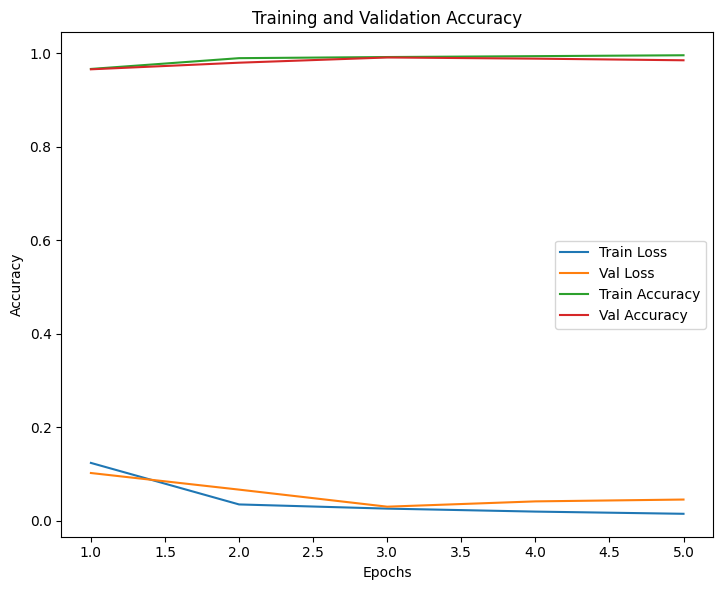

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(14, 6))

    # 绘制 Train Loss 和 Val Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制 Train Accuracy 和 Val Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数绘制图像
plot_training_history(history)